## `wmpy-power` tutorial

This tutorial will demonstrate the basic use of `wmpy-power` in two scenarios:
* First, in calibration mode where model parameters are calibrated to a historical generation dataset
* Second, in simulation mode where previously calibrated model parameters are used to simulate generation

In [1]:
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import psutil
from wmpy_power import Model
from wmpy_power.utilities import download_data

In [2]:
# Download the tutorial data from Zenodo
# By default places the data into the current directory
download_data(data='tutorial', to='./')

https://zenodo.org/records/10530347/files/wmpy_power_tutorial_wauw.zip?download=1: 100%|████████████████████████████████████████████████| 7.75M/7.75M [00:01<00:00, 4.55MB/s]


In [3]:
# set paths to the freshly downloaded tutorial input data
dir_data = './wmpy_power_tutorial/input'
reservoir_parameters_path = f'{dir_data}/wauw-reservoir_parameter.parquet'
monthly_observed_generation_path = f'{dir_data}/wauw-monthly_obs_generation.parquet'
daily_flow_storage_path = f'{dir_data}/wauw-Daymet_VIC4-daily_flow_storage.parquet'
daily_flow_storage_scenario_path = f'{dir_data}/wauw-MPI-ESM1-2-HR-Daymet_VIC4-daily_flow_storage.parquet'


Set output directory

In [4]:
dir_out = './output/'

Instantiate the model. Note that the 'balancing authority' string must match the key found in the 'balancing_authority' column in the reservoir parameters, observed generation, and daily flow and storage datsets. Also note that the random seed, used by the SCE algorithm, can be specified for reproducibility, but is not required.

In [5]:
m = Model(
    calibration_start_year = 2001,
    calibration_end_year = 2013,
    balancing_authority = 'WAUW',
    simulated_flow_and_storage_glob = daily_flow_storage_path,
    observed_hydropower_glob = monthly_observed_generation_path,
    reservoir_parameter_glob = reservoir_parameters_path,
    seed = 500,
    log_to_stdout = False,
    log_to_file = False,
    output_path = dir_out,
    output_type = 'csv',
);


### Calibration
Calibrate the model.

In [6]:
calibrations = m.run();

Plot the modeled hydropower generation against the observed generation for the whole BA and each facility

[<Figure size 5760x5760 with 19 Axes>]

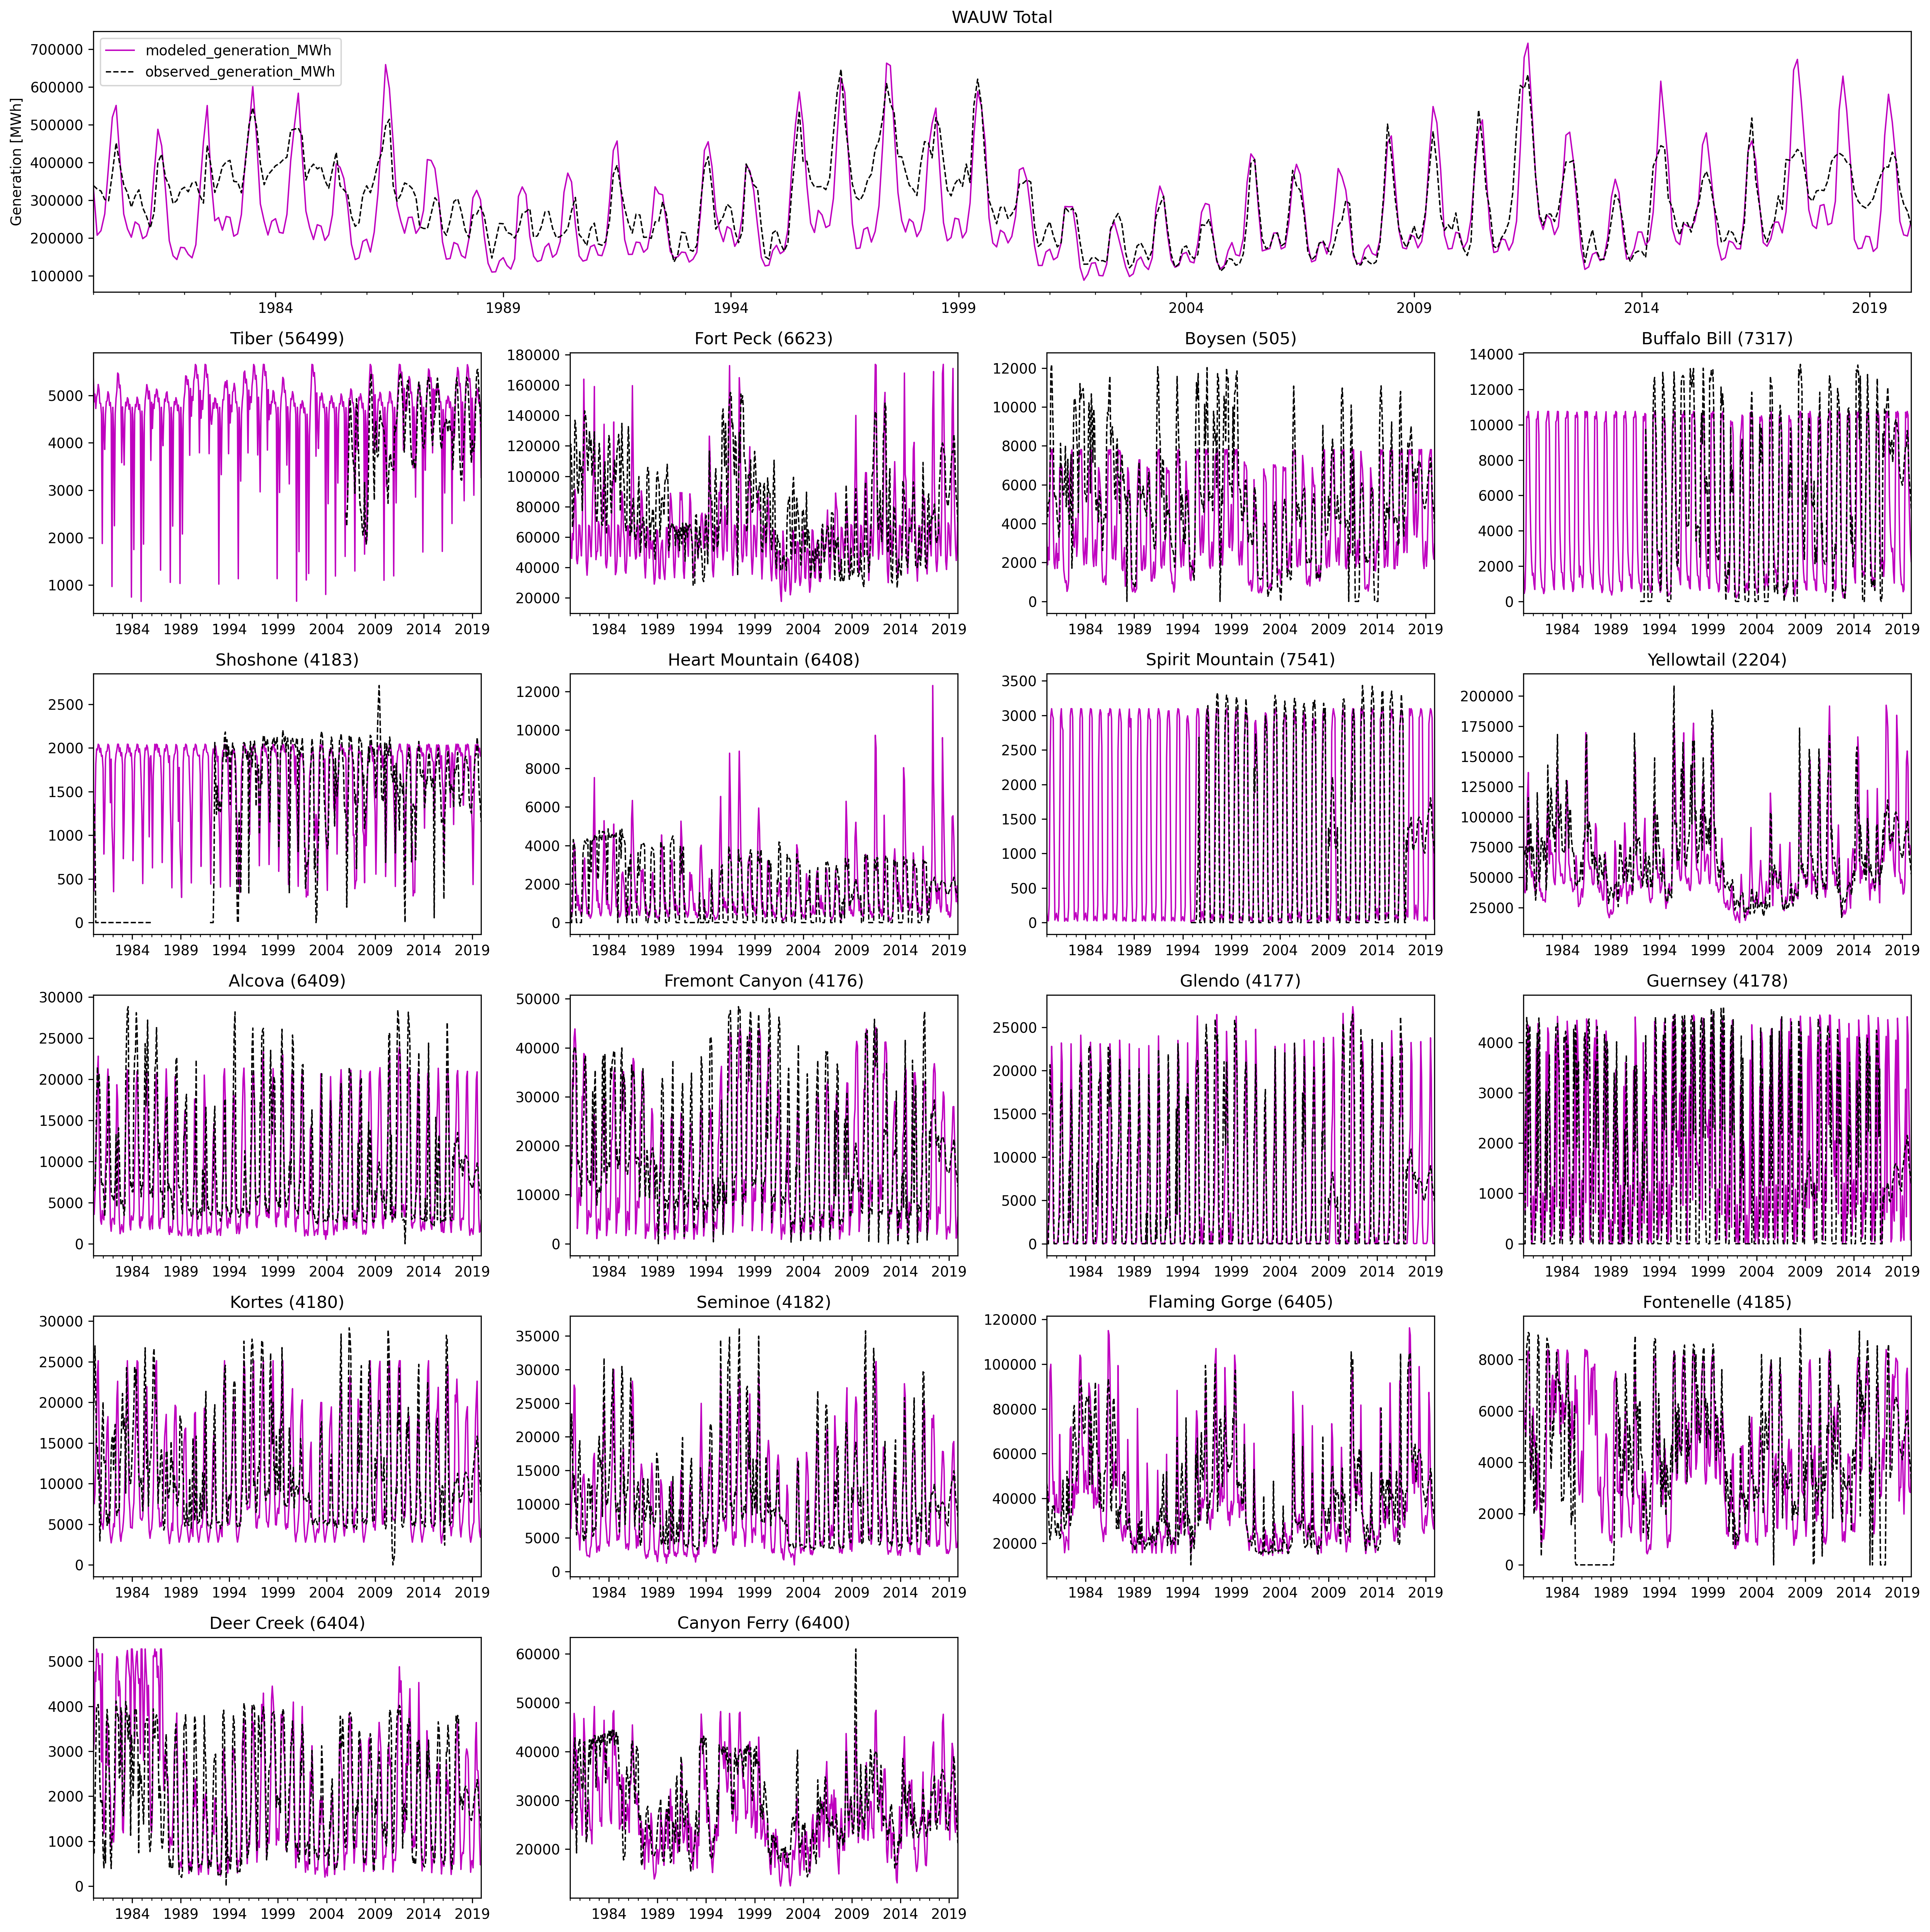

In [7]:
m.plot(calibrations)

<br/>

### Simulation
Using the calibrated parameters, simulate generation for the historical period - using flow and storage data in the 'wauw-Daymet_VIC4-daily_flow_storage.parquet' file.

In [8]:
generation = Model.get_generation(
    calibration_parameters_path = 'output/WAUW_plant_calibrations.csv',
    reservoir_parameters_path = reservoir_parameters_path,
    flow_and_storage_path = daily_flow_storage_path,
    run_name = 'control-Daymet_VIC4',
    start_year = 1980,
    end_year = 2013,
    write_output = True,
    output_csv = True,
    output_path = dir_out
)

<Axes: title={'center': 'WAUW Hydropower Generation [Daymet_VIC4]'}, xlabel='Time', ylabel='Generation [MWh]'>

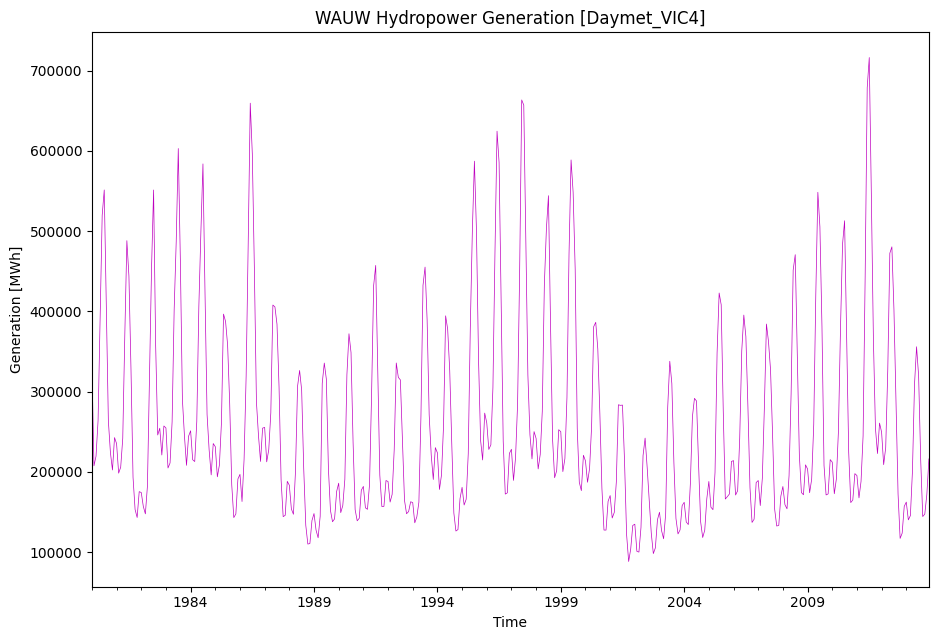

In [9]:
generation.groupby(['date']).modeled_generation_MWh.sum().plot(
    figsize=(10.8, 7.2),
    title='WAUW Hydropower Generation [Daymet_VIC4]',
    ylabel='Generation [MWh]', xlabel='Time',
    style='m-', linewidth=0.5
)

Using the calibrated parameters, simulate generation for the historical period - using flow and storage data in the 'wauw-MPI-ESM1-2-HR-Daymet_VIC4-daily_flow_storage.parquet' file.

In [10]:
generation = Model.get_generation(
    calibration_parameters_path = 'output/WAUW_plant_calibrations.csv',
    reservoir_parameters_path = reservoir_parameters_path,
    flow_and_storage_path = daily_flow_storage_scenario_path,
    run_name = 'cc-MPI-ESM1-2-HR-Daymet_VIC4',
    start_year = 1980,
    end_year = 2059,
    write_output = True,
    output_csv = True,
    output_path = dir_out
)

<Axes: title={'center': 'WAUW Hydropower Generation [MPI-ESM1-2-HR-Daymet_VIC4]'}, xlabel='Time', ylabel='Generation [MWh]'>

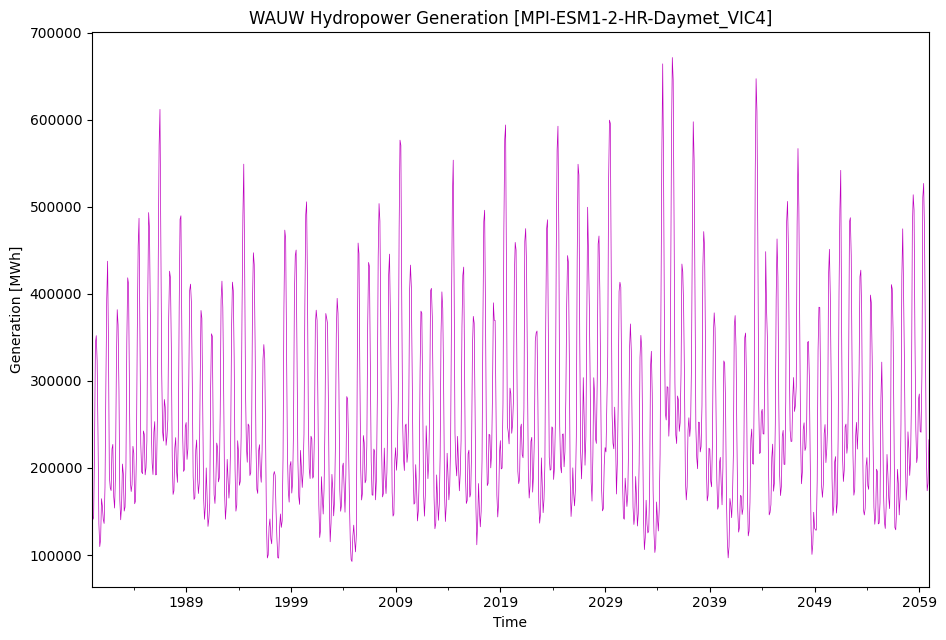

In [11]:
generation.groupby(['date']).modeled_generation_MWh.sum().plot(
    figsize=(10.8, 7.2),
    title='WAUW Hydropower Generation [MPI-ESM1-2-HR-Daymet_VIC4]',
    ylabel='Generation [MWh]', xlabel='Time',
    style='m-', linewidth=0.5
)

### Examining input files
Each input file can be viewed by reading it in as shown below.

In [12]:
reservoir_parameters = pd.read_parquet(reservoir_parameters_path)
hydropower = pd.read_parquet(monthly_observed_generation_path)
flow_storage_control = pd.read_parquet(daily_flow_storage_path)
flow_storage_cc = pd.read_parquet(daily_flow_storage_scenario_path)

In [13]:
reservoir_parameters

eia_plant_id balancing_authority             name  nameplate_capacity_MW  \
0          56499                WAUW            Tiber                    7.5   
1           6623                WAUW        Fort Peck                  179.7   
2            505                WAUW           Boysen                   15.0   
3           7317                WAUW     Buffalo Bill                   18.0   
4           4183                WAUW         Shoshone                    3.0   
5           6408                WAUW   Heart Mountain                    5.0   
6           7541                WAUW  Spirit Mountain                    4.5   
7           2204                WAUW       Yellowtail                  268.8   
8           6409                WAUW           Alcova                   41.4   
9           4176                WAUW   Fremont Canyon                   66.8   
10          4177                WAUW           Glendo                   38.0   
11          4178                WAUW         Guernsey                    6.4   
12          4180                WAUW           Kortes                   36.0   
13          4182                WAUW          Seminoe                   51.6   
14          6405                WAUW    Flaming Gorge                  151.8   
15          4185                WAUW       Fontenelle                   10.0   
16          6404                WAUW       Deer Creek                    4.8   
17          6400                WAUW     Canyon Ferry                   49.8   

    plant_head_m  storage_capacity_m3  use_run_of_river  
0        60.0456         1.193170e+09             False  
1        67.0560         1.899559e+10             False  
2        43.8912         8.652986e+08             False  
3        80.7720         7.975250e+08             False  
4        80.7720         7.975250e+08             False  
5        80.7720         7.975250e+08             False  
6        33.5280         7.975250e+08             False  
7       150.5712         1.258856e+09             False  
8        56.3880         2.274599e+08             False  
9        91.4400         1.253832e+09             False  
10       44.1960         5.604156e+08             False  
11       28.0416         5.626149e+07             False  
12       60.9600         5.845462e+06              True  
13       62.7888         1.254793e+09             False  
14      136.5504         4.673532e+09             False  
15       28.6512         4.259947e+08             False  
16       47.2440         1.881920e+08             False  
17       38.1000         2.401586e+09             False

In [14]:
hydropower

year  month  eia_plant_id  generation_MWh
0     1980      1          6400       38221.193
1     1980      1         56499             NaN
2     1980      1          6623      118182.000
3     1980      1           505        4857.378
4     1980      1          2204       69221.850
...    ...    ...           ...             ...
8635  2019     12          4182        8121.915
8636  2019     12          6409        5325.475
8637  2019     12          4185        3270.623
8638  2019     12          6405       28942.787
8639  2019     12          6404        1286.691

[8640 rows x 4 columns]

In [15]:
flow_storage_control

date  eia_plant_id       flow       storage
0      1980-01-01           505  47.617992  6.081270e+08
1      1980-01-02           505  48.164268  6.039640e+08
2      1980-01-03           505  48.194508  6.006772e+08
3      1980-01-04           505  45.806580  6.016191e+08
4      1980-01-05           505  45.223656  6.045524e+08
...           ...           ...        ...           ...
262975 2019-12-27         56499  68.863724  1.057953e+09
262976 2019-12-28         56499  69.009079  1.056824e+09
262977 2019-12-29         56499  69.117706  1.055140e+09
262978 2019-12-30         56499  66.041557  1.053278e+09
262979 2019-12-31         56499  60.972904  1.051583e+09

[262980 rows x 4 columns]

In [16]:
flow_storage_cc

date  eia_plant_id       flow      storage
0      1980-01-01        6404.0   0.901211  130589744.0
1      1980-01-02        6404.0   1.131926  130689672.0
2      1980-01-03        6404.0   1.132730  130801640.0
3      1980-01-04        6404.0   1.134943  130917672.0
4      1980-01-05        6404.0   0.972300  131036328.0
...           ...           ...        ...          ...
525955 2059-12-27       56499.0  38.036854  971667904.0
525956 2059-12-28       56499.0  37.738796  970448448.0
525957 2059-12-29       56499.0  38.162254  969234880.0
525958 2059-12-30       56499.0  41.247116  968032448.0
525959 2059-12-31       56499.0  38.573616  966851520.0

[525960 rows x 4 columns]